In [1]:
"""

"""

'\n\n'

In [2]:
is_skip = True
# Data params
batch_size = 128
encode_len = 100
pred_len = 30

valid_start_date = "2020-01-01"
hint_days = 30

# Model params
d_model = 128
nhead = 4
d_ff = 256
dropout = 0.1
num_layers = 4

# Import

In [3]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

import torch
from pytorch_model_summary import summary

device = torch.device("cuda:0")

# Data

In [4]:
if not is_skip:
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
    df_raw = pd.merge(df_trans, df_meta, on="article_id")

In [5]:
def preprocess(data, min_size=2):
    data = data.copy()

    # Make sales
    data = data.groupby(["t_dat", "article_id"], as_index=False).agg(sales=("customer_id", "count"))

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["article_id"] = data["article_id"].fillna(method="ffill")
    
    # Data to list
    data = data.groupby("article_id", as_index=False)["sales"].agg(list)

    # Size restriction
    data["size"] = data["sales"].str.len()
    return data

if not is_skip:
    # df_prep = df_raw[df_raw["index_name"]=="Ladieswear"].reset_index(drop=True)
    
    df_train = df_prep[df_prep["t_dat"] < valid_start_date]
    df_train = preprocess(df_train, min_size=encode_len+pred_len)
    df_train.to_parquet("df_train.pq")

    df_valid = df_prep[df_prep["t_dat"] >= valid_start_date]
    df_valid = preprocess(df_valid, min_size=encode_len+pred_len)
    df_valid.to_parquet("df_valid.pq")    

In [6]:
df_train = pd.read_parquet("df_train.pq")
df_valid = pd.read_parquet("df_valid.pq")

df_train = df_train[df_train["size"] >= encode_len+pred_len]
df_valid = df_valid[df_valid["size"] >= encode_len+pred_len]

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, encode_len, pred_len):
        self.encode_len, self.pred_len = encode_len, pred_len
        self.sales_li = []
        
        for _, row in tqdm(data.iterrows()):
            sales = torch.FloatTensor(row["sales"]).unfold(0, encode_len+pred_len, 1)
            self.sales_li.append(sales)
        
        self.sales_li = torch.concat(self.sales_li)
       
    def __len__(self):
        return self.sales_li.shape[0]
    
    def __getitem__(self, idx):
        sales = self.sales_li[idx]
        
        decoder_input = sales[:encode_len].reshape(-1, 1)
        y = sales[-pred_len:].reshape(-1, 1)

        # Scale
        decoder_input = np.log1p(decoder_input)
        y = np.log1p(y)

        return {"decoder_input":decoder_input, 
                "y": y}

train_dataset = Dataset(df_train, encode_len, pred_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = Dataset(df_valid, encode_len, pred_len)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in train_dataloader:
    print("decoder_input:", data["decoder_input"].shape)
    print("y:", data["y"].shape)
    break

0it [00:00, ?it/s]

/tmp/ipykernel_181978/2014991087.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343962757/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  sales = torch.FloatTensor(row["sales"]).unfold(0, encode_len+pred_len, 1)
13822it [00:00, 35061.27it/s]
10157it [00:00, 46394.48it/s]


decoder_input: torch.Size([128, 100, 1])
y: torch.Size([128, 30, 1])


# Architecture

In [7]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, nhead, num_layers, pred_len):
        super().__init__()
        self.pred_len = pred_len
        self.lstm = torch.nn.LSTM(1, d_model)
        self.self_attn = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, batch_first=True), num_layers)
        self.linear = torch.nn.Linear(d_model, 2)

    def get_paddingmask(self, data):
        return torch.where(data==-1, -torch.inf, 0).to(device)

    def forward(self, x):
        # Architecture
        lstm, _ = self.lstm(x)
        self_attn = self.self_attn(lstm)
        self_attn = self_attn[:, -self.pred_len:, :]
        output = self.linear(self_attn)
        return output

model = Transformer(d_model, nhead, num_layers, pred_len)
model.to(device)
summary(model,
        data["decoder_input"].to(device),
        show_parent_layers=True, print_summary=True)

--------------------------------------------------------------------------------------------------------------------------
   Parent Layers            Layer (type)                                      Output Shape         Param #     Tr. Param #
     Transformer                  LSTM-1     [128, 100, 128], [1, 100, 128], [1, 100, 128]          67,072          67,072
     Transformer    TransformerEncoder-2                                   [128, 100, 128]       2,372,096       2,372,096
     Transformer                Linear-3                                      [128, 30, 2]             258             258
Total params: 2,439,426
Trainable params: 2,439,426
Non-trainable params: 0
--------------------------------------------------------------------------------------------------------------------------


'--------------------------------------------------------------------------------------------------------------------------\n   Parent Layers            Layer (type)                                      Output Shape         Param #     Tr. Param #\n==========================================================================================================================\n     Transformer                  LSTM-1     [128, 100, 128], [1, 100, 128], [1, 100, 128]          67,072          67,072\n     Transformer    TransformerEncoder-2                                   [128, 100, 128]       2,372,096       2,372,096\n     Transformer                Linear-3                                      [128, 30, 2]             258             258\n==========================================================================================================================\nTotal params: 2,439,426\nTrainable params: 2,439,426\nNon-trainable params: 0\n----------------------------------------------------

# Train

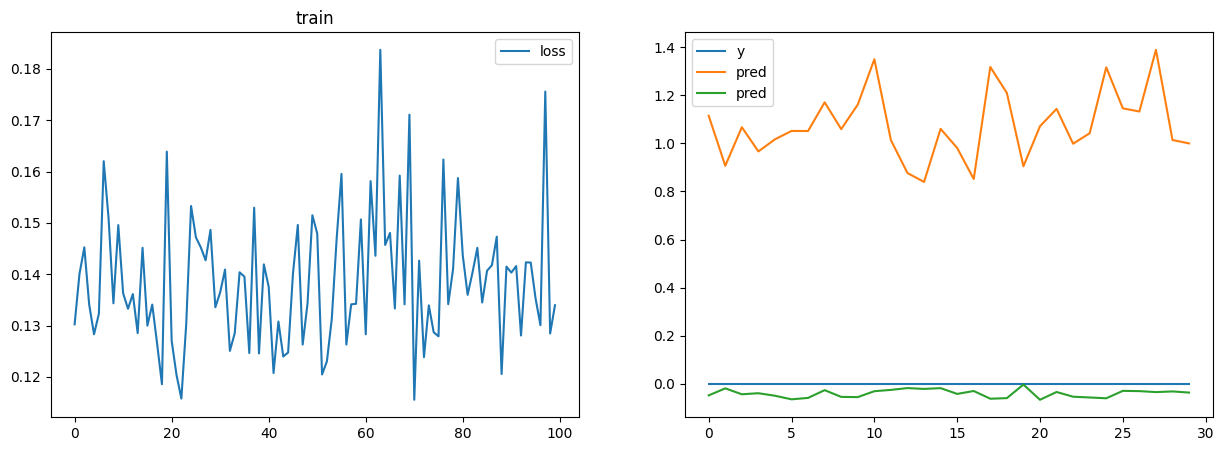

epoch 0 - loss: 0.13863:   1%|▏         | 257/17599 [00:38<44:28,  6.50it/s]

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss = torch.nn.MSELoss()

def loss_fn(upperbound, lowerbound, y):
    outside_interval = torch.max(y - upperbound, torch.zeros(y.shape).to(device)) + torch.max(lowerbound - y, torch.zeros(y.shape).to(device))
    interval_width = upperbound - lowerbound
    interval_penalty = 0.1 * interval_width
    loss = torch.mean(outside_interval + interval_penalty)
    
    return loss

class Report():
    def __init__(self, window, name):
        self.window, self.name = window, name
        self.loss_li = []

    def plot_sample(self, loss_li, y, pred):
        plt.figure(figsize=(15,5))
        nrows, ncols = 1,2

        plt.subplot(nrows, ncols, 1)
        plt.plot(loss_li, label="loss")
        plt.title(self.name)
        plt.legend()

        plt.subplot(nrows, ncols, 2)
        plt.plot(y, label="y")
        plt.plot(pred, label="pred")
        plt.legend()

        plt.show()

    def report(self, loss, y, pred, pbar, e, isplot=False):
        self.loss_li.append(loss.item())
        pbar.set_description(f"epoch {e} - loss: {np.round(np.mean(self.loss_li[-self.window:]), 5)}")
        
        if isplot:
            clear_output(wait=True)
            self.plot_sample(self.loss_li[-self.window:], y[-1], pred[-1])

def train(e):
    model.train()
    pbar = tqdm(train_dataloader)
    report = Report(window=100, name="train")

    for n, data in enumerate(pbar):
        optimizer.zero_grad()
        pred = model(data["decoder_input"].to(device))
        upperbound = pred[:, :, 0:1]
        lowerbound = pred[:, :, -1:]
        loss = loss_fn(upperbound, lowerbound, data["y"].to(device))

        loss.backward()
        optimizer.step()

        report.report(loss, 
                    np.expm1(data["y"].squeeze(-1).detach().cpu().numpy()), 
                    np.expm1(pred.squeeze(-1).detach().cpu().numpy()), 
                    pbar, e, isplot=True)

epoch = 10
for e in range(epoch):
    train(e)
    # valid(e)

# Eval

In [ ]:
model.eval()
pbar = tqdm(valid_dataloader)
report = Report(window=100, name="valid")

for n, data in enumerate(pbar):
    with torch.no_grad():
        pred = model(data["decoder_input"].to(device))
        upperbound = pred[:, :, 0:1]
        lowerbound = pred[:, :, -1:]
        loss = loss_fn(upperbound, lowerbound, data["y"].to(device))

        report.report(loss, 
                    np.expm1(data["y"].squeeze(-1).detach().cpu().numpy()), 
                    np.expm1(pred.squeeze(-1).detach().cpu().numpy()), 
                    pbar, e, isplot=True)
        # break

epoch 0 - loss: 0.10378:   0%|          | 428/838888 [00:52<28:41:44,  8.12it/s]


KeyboardInterrupt: 